The purpose of this notebook is to represent two masses connected via springs using a wiring diagram.

![Cat](https://raw.githubusercontent.com/rgCategory/composition_notebook/main/images/spring_mass.png)

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [3]:
# Function to display diagram
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)

show_diagram (generic function with 1 method)

Ideally one could represent the feedback loop between the boxes with a single wire. However, if this example is compiled one gets an error involving array indexing. 

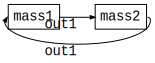

In [4]:
# Assume the diagram is closed and contains no inputs or outputs.
spring_damper = WiringDiagram( [], [] ) 

# Each box has a single input and output
box_mass1 = add_box!(spring_damper, Box(:mass1, [:in1], [:out1]) )
box_mass2 = add_box!(spring_damper, Box(:mass2, [:in1], [:out1]) )

# Interconect system
add_wires!( spring_damper, [
            (box_mass1, 1) => (box_mass2, 1),
            (box_mass2, 1) => (box_mass1, 1)
        ])   

# Display diagram
show_diagram(spring_damper)

One solution is to add more wires to the system. Each wire represents one of the states used by the boxes to communicate.

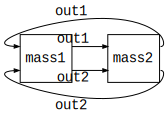

In [5]:
# Assume the diagram is closed and contains no inputs or outputs.
spring_damper = WiringDiagram( [], [] ) 

# Each box has two inputs and two outputs
box_mass1 = add_box!(spring_damper, Box(:mass1, [:in1, :in2], [:out1, :out2]) )
box_mass2 = add_box!(spring_damper, Box(:mass2, [:in1, :in2], [:out1, :out2]) )

# Connect the system - 2 wires per box
add_wires!( spring_damper, [
            (box_mass1, 1) => (box_mass2, 1),
            (box_mass2, 1) => (box_mass1, 1),
            (box_mass1, 2) => (box_mass2, 2),
            (box_mass2, 2) => (box_mass1, 2)
        ])   

# Display diagram
show_diagram(spring_damper)

Unfortunately this system uses a lot of wires. It's okay with just two states, but if the system is more complex the amount of wires becomes unwieldy.

In [7]:
# Spring and damping constant of each mass.
k_spring1 = 1;      # Mass #1:
c_damp1 = 1.0;

k_spring2 = 5;     # Mass #2:
c_damp2 = 10.0;
     
# Reaction of outer spring
accel_2(u, x) = k_spring2*(x[1] - u[1]) + c_damp2*(x[2] - u[2]);     
                        
# Equations of each mass: 
eq_mass1(u, x, p, t) = [ u[2], -k_spring1*u[1] - c_damp1*u[2] + accel_2(u,x)];                
eq_mass2(u, x, p, t) = [ u[2], accel_2(u,x) ];

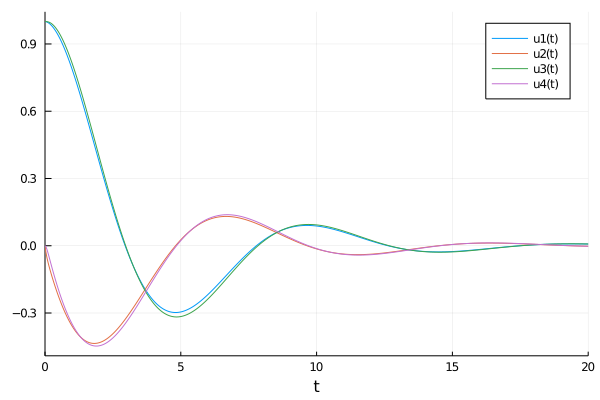

In [9]:
# Define state machines for each box:
mass1_machine = ContinuousMachine{Float32}( 2,			# Inputs: pos and vel
                                            2,			# States
                                            2, 		    # Outputs: pos and vel
                                            eq_mass1,   # Input function
                                            u -> u);    # State is transformed into the state

mass2_machine = ContinuousMachine{Float32}( 2, 2, 2, eq_mass2, u -> u);

# Compose the system
spring_damper_machine = oapply(spring_damper, [mass1_machine, mass2_machine] );


# Initial conditions
u_init = [1, 0, 1, 0];       # There are 4 initial states: p1, v1, and p2, v2

# Interval of solution
t_span = (0, 20);      

# Solve ODE:          Note: y'' = -K.y - c*y' is stiff
sol = solve( ODEProblem(spring_damper_machine, u_init, t_span), alg_hints=[:stiff] );

plot(sol)

This result makes sense, in that the second mass follows the first very closely as it has a stiff spring. However, if you remove wires from the diagram the output becomes wildly different. The explicit connected seems to be the only way to obtain a reasonable output.